# OSGD GAN Project - Learining a Distribution
In this notebook we aim to make a GAN that learns and can produce realistic samples from a normal distribution.

We provide the model with a training set of samples from the normal distribution that we want the model to learn, and after a training period we hope that the generator element of the model can produce a sample indistinguishable from those in the training set.

### Contents
1. Setup
2. Discriminator Network
3. Genarator Network
4. Misc Functions
5. Training Function For The Discriminator
6. Training Function For The Generator
7. Main Training Function
8. Training & Testing
9. Comments / To Do

## 1. Setup

In [1]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable

import math 
import seaborn as sns # To plot graphs

In [2]:
# Constants - Used throughout
BATCH_SIZE = 50 # Training Batch Size
N_EPOCHS = 1000
LR = 0.0002 # Learning Rate

In [3]:
# Ground truth data
data = torch.randn(2000) # Some N(0,1) random numbers, used as source data

## 2. Discriminator Network

In [4]:
class Discriminator(torch.nn.Module):
    #Input : A real number
    #Output : Probability input is from a normal distribution
    
    def __init__(self):
        super(Discriminator,self).__init__()
        
        # Sets expected input and output size
        input_size = 1
        output_size = 1
        
        # Neural network layers
        self.hidden0 = nn.Sequential( 
            nn.Linear(input_size, 16),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(16, 8),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(8, 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(4, output_size),
            torch.nn.Sigmoid() # Sigmoid activation layer, so value out is in (0,1) representing a probability
        )
        
    def forward(self,x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

## 3. Genarator Network

In [5]:
class Generator(torch.nn.Module):
    #Input: Noise sampled from U(0,1)
    #Output: Hopefully someting from the normal distribution that we're trying to learn
    
    def __init__(self):
        super(Generator,self).__init__()
        
        # Sets expected input and output size
        input_size = 1
        output_size = 1
        
        # Neural network layers
        self.hidden0 = nn.Sequential(
            nn.Linear(input_size,16),
            nn.LeakyReLU(0.1)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(16,16),
            nn.LeakyReLU(0.1)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(16,8),
            nn.LeakyReLU(0.1)
        )
        self.out = nn.Sequential(
            nn.Linear(8,output_size)
            # Note: Don't want an activiation function here, as would mess with output, or do we??
        )
        
    def forward(self,x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

## 4. Misc Functions

In [6]:
discriminator = Discriminator()
generator = Generator()

In [7]:
def noise(n):
    # Input: An integer n, the number of samples to make
    # Output: A tensor of length n, of random values

    return Variable(torch.randn(n)).view(n,1)

In [8]:
def ones_target(n):
    # Input: An integer n
    # Output: Tensor of 1's length n
    
    return Variable(torch.ones(n,1))

In [9]:
def zeros_target(n):
    # Input: An integer n
    # Output: Tensor of 0's length n
    
    return Variable(torch.zeros(n,1))

## 5. Training Function For The Discriminator

In [10]:
# Specifies optimiser
optimiser_d = optim.Adam(discriminator.parameters(), LR)

def update_discriminator(generated_data,real_data):
    # Input: generated_data (from generator), real_data (from data tensor)
    # Output: Loss for discriminator
    
    optimiser_d.zero_grad() # Clears gradient
    loss = nn.BCELoss()
    N = real_data.size(0) # Number of data items
    
    if generated_data.size(0)!=N:
        raise Exception('Need generated_data & real_data to be the same size!')
    
    # Apply discriminator to each element in real_data union generated_data
    x = discriminator(torch.cat([real_data,generated_data]))
    
    # Create targets
    y = torch.cat([ones_target(N),zeros_target(N)]) # 1's for real data, 0's for fake data
    
    # Calculate loss and backprop
    error = loss(x,y)
    error.backward()
    
    # Updates network
    optimiser_d.step()
    
    # Return total error and predictions
    return error.detach().numpy(),x.detach().numpy().flatten()

## 6. Training Function For The Generator

In [11]:
# Specifies optimizer
optimiser_g = optim.Adam(generator.parameters(), LR)

def update_generator(generated_data):
    # Input: generated_data (from generator)
    # Output: loss for generator
    
    optimiser_g.zero_grad() # Clears gradient
    loss = nn.BCELoss()
    N = generated_data.size(0) # Number of data items
    
    # Apply discriminator to each element in generated_data
    x = discriminator(generated_data)
    
    # Create targets
    y = ones_target(N) # Want target to be 1's, opposite of disciminator's aim
    
    # Calculates loss and backprop
    error = loss(x,y) 
    error.backward()
    
    # Updates network
    optimiser_g.step()
    
    # Return error
    return error.detach().numpy()  

## 7. Main Training Function

In [12]:
def train():
    # Trains the GAN
    
    for e in range(N_EPOCHS):
        k = math.ceil(len(data)/BATCH_SIZE) # Number of loops to see all the real data
        for f in range(k):

            # Get minibatch of real data
            start, end = f*BATCH_SIZE,(f+1)*BATCH_SIZE # Note: end may be larger than end data
            real_data = data[start:end]
            real_data = real_data.view(real_data.size(0), 1) # Sets correct view
            
            # Get minibatch of generated data
            generated_data = generator(noise(real_data.size(0))).detach() # Detach so generator grad isn't affected
            
            # Optimise discriminator
            d_error,d_pred = update_discriminator(generated_data,real_data)
            
        
        # Optimise generator, with new batch of generated data
        generated_data = generator(noise(BATCH_SIZE))
        g_error = update_generator(generated_data)
    
        # Debugg/Progress output
        if (e+1)%100==0:
            print("Training "+str((e+1)/N_EPOCHS*100)+"% Complete:")
            print("\t Generator Loss =     "+str(g_error))
            print("\t Discriminator Loss = "+str(d_error))
            
            print("\t\t pred on real data "+str(d_pred[:5])) # Prints 5 predictions on real data (discrim wants this to be 1, we want 0.5)
            print("\t\t pred on fake data "+str(d_pred[-5:])) # Prints 5 predictions on fake data (discrim wants this to be 1, we want 0.5)

## 8. Training & Testing

In [24]:
train()

Training 10.0% Complete:
	 Generator Loss =     0.68335366
	 Discriminator Loss = 0.68925667
		 pred on real data [0.4964919  0.48555413 0.50260574 0.46585935 0.516171  ]
		 pred on fake data [0.49888003 0.4583487  0.5005512  0.49666062 0.47242773]
Training 20.0% Complete:
	 Generator Loss =     0.69259894
	 Discriminator Loss = 0.68922126
		 pred on real data [0.49078172 0.49602205 0.50605404 0.45182285 0.50865215]
		 pred on fake data [0.4956945  0.48043975 0.49902546 0.51093626 0.50331765]
Training 30.0% Complete:
	 Generator Loss =     0.6924582
	 Discriminator Loss = 0.6935122
		 pred on real data [0.5091288  0.4966238  0.50332075 0.50740314 0.5084713 ]
		 pred on fake data [0.49249902 0.5057772  0.49976194 0.50642145 0.49138936]
Training 40.0% Complete:
	 Generator Loss =     0.69481015
	 Discriminator Loss = 0.6911272
		 pred on real data [0.5073259  0.5007587  0.50313044 0.49974608 0.5070283 ]
		 pred on fake data [0.50513726 0.50731385 0.50851405 0.49843213 0.5007048 ]
Trainin

In [14]:
def test():
    x = generator(noise(500)).detach().numpy()
    sns.distplot(x) # Produces a pdf estimate for the generator's values

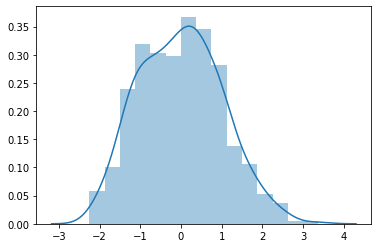

In [43]:
test() # Plots a density estimate for the distribution produced by the generator

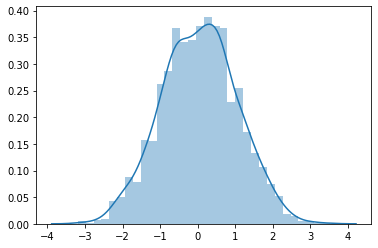

In [16]:
sns.distplot(data) # Plots the distribution for the real/source data

In [17]:
print(generator(noise(10)).detach()) # An idea of the number the generator produces

tensor([[ 0.4609],
        [ 0.2612],
        [-0.0318],
        [ 0.4680],
        [ 1.8987],
        [ 0.0178],
        [-0.2042],
        [ 1.3654],
        [-1.4013],
        [-0.0932]])


## 9. Comments / To Do

1. Mess around with N_EPOCHS and Batch size, auto detect when network converges??
2. Mess around with different sized layers in the nn's
3. Still not sure about activation function for generator
4. Fix all that then wrap up nicely in a GAN object
5. Maybe find a way to animate the training process